# Why Dask
- Lazy processing
- Large file (not fitting in the memory)
- Parallelization (use all available computational resources)

# Imaport and init Dask

### Jupyter lab extension

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:54128")
client

<Client: 'tcp://127.0.0.1:54128' processes=4 threads=8, memory=16.98 GB>

In [2]:
# Dask imports
import dask.array as da

# non-Dask imports
import numpy as np

# Using Dask arrays instead of Numpy

Dask arrays coordinate many Numpy arrays, arranged into chunks within a grid. They support a large subset of the Numpy API.

In [5]:
x = np.random.random((100000,10000,100))
x

MemoryError: 

In [12]:
# Dask Version
x = da.random.random((10000, 10000), chunks=(1000, 1000))
x

dask.array<random_sample, shape=(10000, 10000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [26]:
y = x + x.T
z = y[::2, 5000:].mean(axis=1)
z

dask.array<mean_agg-aggregate, shape=(5000,), dtype=float64, chunksize=(500,), chunktype=numpy.ndarray>

In [27]:
k = z.compute() #Lazy computation

In [29]:
type(k)

dask.array.core.Array

If you have the available RAM for your dataset then you can persist data in memory (it is faster and does not need to run the pipeline from the begining).



In [21]:
z = z.persist()
z[0].compute()

0.9995937526013775

In [23]:
z.mean().compute()

1.000049891392585

# Dask Bag (map, filter, reduce)
https://docs.dask.org/en/latest/bag-api.html

Dask Bag implements operations like map, filter, reductions and aggregations on collections of Python objects

In [3]:
import dask
import json
import os

# os.makedirs('data', exist_ok=True) # Create data/ directory

b = dask.datasets.make_people() # Make records of people; it is a Dask Bag; this is lazy and won't generate unless you call an excutive like compute() or take() or ...
# b.take(2)
# type(b)

In [36]:
txt = b.map(json.dumps) #map function applies a function on all members of a bag and it do it in parallel fashion
txt.take(2)
# type(txt)

('{"age": 55, "name": ["Thomas", "Ford"], "occupation": "Medical Researcher", "telephone": "748-053-9773", "address": {"address": "1257 Java Wynd", "city": "Grand Junction"}, "credit-card": {"number": "3784 404068 11887", "expiration-date": "07/20"}}',
 '{"age": 23, "name": ["Shera", "Cook"], "occupation": "Servant", "telephone": "1-429-800-5837", "address": {"address": "1302 James Alley", "city": "Garden City"}, "credit-card": {"number": "4930 1461 1373 6662", "expiration-date": "07/22"}}')

In [15]:
b.map(json.dumps).to_textfiles('data/*.json')   # You can make a parallel pipline by unsing .

["C:/Amin's Personal Data/University/Teaching/Winter 2020/Special Topics in Data Science, Winter 2020/Jupyter Notebooks/7-Dask/data/0.json",
 "C:/Amin's Personal Data/University/Teaching/Winter 2020/Special Topics in Data Science, Winter 2020/Jupyter Notebooks/7-Dask/data/1.json",
 "C:/Amin's Personal Data/University/Teaching/Winter 2020/Special Topics in Data Science, Winter 2020/Jupyter Notebooks/7-Dask/data/2.json",
 "C:/Amin's Personal Data/University/Teaching/Winter 2020/Special Topics in Data Science, Winter 2020/Jupyter Notebooks/7-Dask/data/3.json",
 "C:/Amin's Personal Data/University/Teaching/Winter 2020/Special Topics in Data Science, Winter 2020/Jupyter Notebooks/7-Dask/data/4.json",
 "C:/Amin's Personal Data/University/Teaching/Winter 2020/Special Topics in Data Science, Winter 2020/Jupyter Notebooks/7-Dask/data/5.json",
 "C:/Amin's Personal Data/University/Teaching/Winter 2020/Special Topics in Data Science, Winter 2020/Jupyter Notebooks/7-Dask/data/6.json",
 "C:/Amin's P

### Work with jsons, in two different fashions

In [51]:
%%time

# standard way
import json
from os import walk

data =[]
for (dirpath, dirnames, filenames) in walk('data'):
    for file in filenames:
        filepath = 'data/' + file
        with open(filepath) as json_file:
#             print (filepath)
            for line in json_file:
                 data.append(json.loads(line))
len(data)

Wall time: 22 s


1879000

In [4]:
%%time

#dask way
import dask.bag as db
import json

b = db.read_text('data/*.json').map(json.loads)
b.count().compute()

Wall time: 7.86 s


1879000

In [5]:
b

dask.bag<loads-9..., npartitions=25>

#### Filters

In [53]:
%%time

# standard way
p30 =[]
for per in data:
    if per['age'] > 30:
        p30.append(per)
        
len(p30)

Wall time: 948 ms


1322942

In [63]:
%%time

# Dask way
b.filter(lambda item: item['age'] > 30).take(2)

Wall time: 26.7 ms


({'age': 59,
  'name': ['Merrill', 'Marquez'],
  'occupation': 'Labelling Operator',
  'telephone': '+1-(714)-149-1573',
  'address': {'address': '1400 Lysette Road', 'city': 'Oak Creek'},
  'credit-card': {'number': '3768 395862 07828', 'expiration-date': '01/23'}},
 {'age': 49,
  'name': ['Clorinda', 'Whitaker'],
  'occupation': 'Occupations',
  'telephone': '509.041.0419',
  'address': {'address': '889 Crestline Annex', 'city': 'Manchester'},
  'credit-card': {'number': '5158 0517 9724 8012',
   'expiration-date': '05/24'}})

In [64]:
# powerful pipelining of bags
result = (b.filter(lambda record: record['age'] > 30).map(lambda record: record['occupation']).frequencies(sort=True).topk(10, key=1))
result.compute()

[('Gravel Merchant', 5731),
 ('Video Artist', 5044),
 ('Garden Designer', 4413),
 ('Thermal Insulator', 4378),
 ('Cafe Owner', 4362),
 ('Technical Author', 4343),
 ('Insurance Staff', 4232),
 ('Cartoonist', 3854),
 ('Auxiliary Nurse', 3804),
 ('Cable TV Installer', 3804)]

#### write to disk for future

In [6]:
(b.filter(lambda record: record['age'] > 30)
.map(json.dumps) # Convert Python objects to text
.to_textfiles('data/processed.*.json')) # It will generate a file for each partition and * will be replaced by a sequence 0, 1, 2, ... . You can introduce a name finction for file names, using name_function argument

# other formats like avro are available, read https://docs.dask.org/en/latest/bag-api.html#turn-bags-into-other-things

["C:/Amin's Personal Data/University/Teaching/Winter 2020/Special Topics in Data Science, Winter 2020/Jupyter Notebooks/7-Dask/data/processed.00.json",
 "C:/Amin's Personal Data/University/Teaching/Winter 2020/Special Topics in Data Science, Winter 2020/Jupyter Notebooks/7-Dask/data/processed.01.json",
 "C:/Amin's Personal Data/University/Teaching/Winter 2020/Special Topics in Data Science, Winter 2020/Jupyter Notebooks/7-Dask/data/processed.02.json",
 "C:/Amin's Personal Data/University/Teaching/Winter 2020/Special Topics in Data Science, Winter 2020/Jupyter Notebooks/7-Dask/data/processed.03.json",
 "C:/Amin's Personal Data/University/Teaching/Winter 2020/Special Topics in Data Science, Winter 2020/Jupyter Notebooks/7-Dask/data/processed.04.json",
 "C:/Amin's Personal Data/University/Teaching/Winter 2020/Special Topics in Data Science, Winter 2020/Jupyter Notebooks/7-Dask/data/processed.05.json",
 "C:/Amin's Personal Data/University/Teaching/Winter 2020/Special Topics in Data Science

In [7]:
b.take(2)

({'age': 59,
  'name': ['Merrill', 'Marquez'],
  'occupation': 'Labelling Operator',
  'telephone': '+1-(714)-149-1573',
  'address': {'address': '1400 Lysette Road', 'city': 'Oak Creek'},
  'credit-card': {'number': '3768 395862 07828', 'expiration-date': '01/23'}},
 {'age': 22,
  'name': ['Devorah', 'Tate'],
  'occupation': 'Lineman',
  'telephone': '973.901.7788',
  'address': {'address': '430 Mason Walk', 'city': 'Southlake'},
  'credit-card': {'number': '4950 3868 1981 2368',
   'expiration-date': '04/23'}})

In [72]:
# Convert Dask Bag to Dask Dataframe
dd = b.to_dataframe()
dd.head()

age                  name          occupation          telephone  \
0   59    [Merrill, Marquez]  Labelling Operator  +1-(714)-149-1573   
1   22       [Devorah, Tate]             Lineman       973.901.7788   
2   49  [Clorinda, Whitaker]         Occupations       509.041.0419   
3   58     [Chantay, Carver]             Riveter     (247) 193-4932   
4   57         [Maile, Howe]              Grocer     1-658-619-6032   

                                             address  \
0  {'address': '1400 Lysette Road', 'city': 'Oak ...   
1  {'address': '430 Mason Walk', 'city': 'Southla...   
2  {'address': '889 Crestline Annex', 'city': 'Ma...   
3   {'address': '1093 Diana Bay', 'city': 'Mission'}   
4  {'address': '860 Frederick Viaduct', 'city': '...   

                                         credit-card  
0  {'number': '3768 395862 07828', 'expiration-da...  
1  {'number': '4950 3868 1981 2368', 'expiration-...  
2  {'number': '5158 0517 9724 8012', 'expiration-...  
3  {'number': '4455 8800 9146 6208', 'expiration-...  
4  {'number': '2236 1264 5327 2747', 'expiration-...

In [75]:
b.take(1)

({'age': 59,
  'name': ['Merrill', 'Marquez'],
  'occupation': 'Labelling Operator',
  'telephone': '+1-(714)-149-1573',
  'address': {'address': '1400 Lysette Road', 'city': 'Oak Creek'},
  'credit-card': {'number': '3768 395862 07828', 'expiration-date': '01/23'}},)

In [73]:
# flatten some of the composed values in JSON
def flatten(record):
    return {
        'age': record['age'],
        'occupation': record['occupation'],
        'telephone': record['telephone'],
        'credit-card-number': record['credit-card']['number'],
        'credit-card-expiration': record['credit-card']['expiration-date'],
        'name': ' '.join(record['name']),
        'street-address': record['address']['address'],
        'city': record['address']['city']
    }

In [74]:
dd = b.map(flatten).to_dataframe()
dd.head()

age          occupation          telephone   credit-card-number  \
0   59  Labelling Operator  +1-(714)-149-1573    3768 395862 07828   
1   22             Lineman       973.901.7788  4950 3868 1981 2368   
2   49         Occupations       509.041.0419  5158 0517 9724 8012   
3   58             Riveter     (247) 193-4932  4455 8800 9146 6208   
4   57              Grocer     1-658-619-6032  2236 1264 5327 2747   

  credit-card-expiration               name         street-address  \
0                  01/23    Merrill Marquez      1400 Lysette Road   
1                  04/23       Devorah Tate         430 Mason Walk   
2                  05/24  Clorinda Whitaker    889 Crestline Annex   
3                  07/20     Chantay Carver         1093 Diana Bay   
4                  06/22         Maile Howe  860 Frederick Viaduct   

           city  
0     Oak Creek  
1     Southlake  
2    Manchester  
3       Mission  
4  Wilkes-Barre

# Using Dask Dataframe instead of Pandas Dataframe

API documentation: https://docs.dask.org/en/latest/dataframe.html

Very similar to Panadas, so less efforts to learn it.

Dask DataFrames coordinate many Pandas DataFrames/Series arranged along the index. A Dask DataFrame is partitioned row-wise, grouping rows by index value for efficiency. These Pandas objects may live on disk or on other machines.

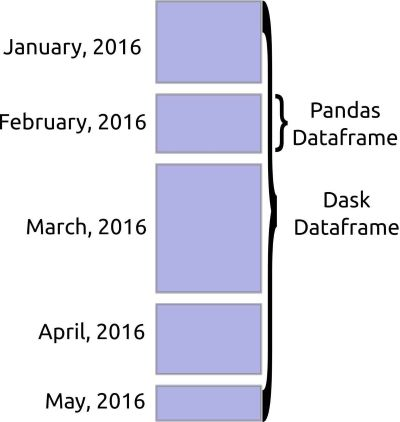

### Dask dataframe use cases

+ Manipulating large datasets, even when those datasets don’t fit in memory
+ Accelerating long computations by using many cores
+ Distributed computing on large datasets with standard Pandas operations like groupby, join, and time series computations

### Do not use it for the followings:

+ If your dataset fits comfortably into RAM on your laptop, then you may be better off just using Pandas. There may be simpler ways to improve performance than through parallelism
+ If your dataset doesn’t fit neatly into the Pandas tabular model, then you might find more use in dask.bag or dask.array
+ If you need functions that are not implemented in Dask DataFrame, then you might want to look at dask.delayed which offers more flexibility
+ If you need a proper database with all that databases offer you might prefer something like Postgres

In [5]:
import dask
df = dask.datasets.timeseries()
df
# when you are dealing with big data partition key (in Dask known as index) is a very important factor in performance

Dask DataFrame Structure:
                   id    name        x        y
npartitions=30                                 
2000-01-01      int32  object  float64  float64
2000-01-02        ...     ...      ...      ...
...               ...     ...      ...      ...
2000-01-30        ...     ...      ...      ...
2000-01-31        ...     ...      ...      ...
Dask Name: make-timeseries, 30 tasks

In [10]:
df.head()

id     name         x         y
timestamp                                             
2000-01-01 00:00:00  1006   Ingrid -0.461196  0.988106
2000-01-01 00:00:01   969   Yvonne -0.683278 -0.075878
2000-01-01 00:00:02  1008   George -0.360517  0.699512
2000-01-01 00:00:03   933  Norbert -0.339832  0.334671
2000-01-01 00:00:04  1004    Jerry  0.787756 -0.818131

In [11]:
import os
import datetime

if not os.path.exists('data/timeseries'):
    os.mkdir('data/timeseries')

def name(i):
    return str(datetime.date(2000, 1, 1) + i * datetime.timedelta(days=1))
    
df.to_csv('data/timeseries/*.csv', name_function=name);

In [9]:
import pandas as pd
df = pd.read_csv('data/timeseries/2000-01-01.csv')
# type(df['timestamp'][0])
df.head()

timestamp    id     name         x         y
0  2000-01-01 00:00:00  1006   Ingrid -0.461196  0.988106
1  2000-01-01 00:00:01   969   Yvonne -0.683278 -0.075878
2  2000-01-01 00:00:02  1008   George -0.360517  0.699512
3  2000-01-01 00:00:03   933  Norbert -0.339832  0.334671
4  2000-01-01 00:00:04  1004    Jerry  0.787756 -0.818131

In [12]:
from dask.dataframe import DataFrame
df = dask.dataframe.read_csv("data/timeseries/2000-01-01.csv", parse_dates=['timestamp'])
df

Dask DataFrame Structure:
                    timestamp     id    name        x        y
npartitions=1                                                 
               datetime64[ns]  int64  object  float64  float64
                          ...    ...     ...      ...      ...
Dask Name: from-delayed, 3 tasks

In [23]:
df.head()

timestamp    id     name         x         y
0 2000-01-01 00:00:00  1006   Ingrid -0.461196  0.988106
1 2000-01-01 00:00:01   969   Yvonne -0.683278 -0.075878
2 2000-01-01 00:00:02  1008   George -0.360517  0.699512
3 2000-01-01 00:00:03   933  Norbert -0.339832  0.334671
4 2000-01-01 00:00:04  1004    Jerry  0.787756 -0.818131

In [21]:
# read all files in a folder with a pattern and put them in partitions
df = dask.dataframe.read_csv("data/timeseries/2000-*-*.csv", parse_dates=['timestamp'])
df

dask.dataframe.core.DataFrame

In [23]:
df = df.set_index('timestamp')
df

Dask DataFrame Structure:
                        id    name        x        y
npartitions=30                                      
2000-01-01 00:00:00  int64  object  float64  float64
2000-01-02 00:00:00    ...     ...      ...      ...
...                    ...     ...      ...      ...
2000-01-30 00:00:00    ...     ...      ...      ...
2000-01-30 23:59:59    ...     ...      ...      ...
Dask Name: sort_index, 150 tasks

In [26]:
# The index enables me to answer queries much faster when it falls within a partition
# Dask will be able to narrow down search instead of looking all paritions for matching records

# df.loc['2000-01-01 03'].compute()
df.loc['2000-01-01 01'].count().compute()

id      3600
name    3600
x       3600
y       3600
dtype: int64

In [27]:
# each Dask dataframe is set of Pandas dataframe, called partition
# to apply regular Pandas function on each partition of a Dask dataframe use map_partitions(func)
df.map_partitions(len).compute()

0     86400
1     86400
2     86400
3     86400
4     86400
5     86400
6     86400
7     86400
8     86400
9     86400
10    86400
11    86400
12    86400
13    86400
14    86400
15    86400
16    86400
17    86400
18    86400
19    86400
20    86400
21    86400
22    86400
23    86400
24    86400
25    86400
26    86400
27    86400
28    86400
29    86400
dtype: int64

In [32]:
%time df.groupby('name').x.mean().compute()

Wall time: 2.93 s


name
Alice       0.000229
Bob         0.002511
Charlie    -0.000799
Dan         0.002245
Edith       0.000790
Frank       0.000116
George     -0.004023
Hannah     -0.002292
Ingrid      0.000842
Jerry      -0.000606
Kevin      -0.002586
Laura       0.000673
Michael    -0.002084
Norbert     0.001373
Oliver      0.001485
Patricia   -0.002201
Quinn      -0.001425
Ray        -0.000498
Sarah       0.002156
Tim        -0.003648
Ursula      0.000534
Victor      0.000799
Wendy       0.000386
Xavier     -0.000049
Yvonne     -0.003026
Zelda       0.001076
Name: x, dtype: float64

In [33]:
%time df.groupby('name').agg({'x': ['mean', 'std'], 'y': ['mean', 'count']}).compute().head()

Wall time: 3.01 s


x                   y       
             mean       std      mean  count
name                                        
Alice    0.000229  0.577833 -0.001036  99890
Bob      0.002511  0.576614  0.001442  99300
Charlie -0.000799  0.577679  0.000855  99600
Dan      0.002245  0.576723 -0.002482  99836
Edith    0.000790  0.576349  0.000113  99729

In [77]:
# Computational graph of a single output aggregation (for a small number of groups, like 1000)
df.groupby('name').x.mean().visualize(node_attr={'penwidth': '6'})
# df.groupby('name').x.mean().compute()

In [78]:
# If the output is large, then you can split the output too. Computational graph of an aggregation to four outputs (for a larger number of groups, like 1000000)
df.groupby('name').x.mean(split_out=4).visualize(node_attr={'penwidth': '6'})
# df.groupby('name').x.mean(split_out=4).compute()

## Write to Parquet
https://parquet.apache.org/documentation/latest/

Parquet is a columnar file format in Hadoop ecosystem available to many languages and models. It's super efficient on top of HDFS.

Parquet has the following benefits:
+ It's a columnar storage (very helpful when working with a part of data; also provides better options for compression)
+ Keeps the index and partitions as is (CSV doesn't)

In [16]:
df.to_parquet('data/timeseries/2000-01.parquet', engine='pyarrow')

In [17]:
df_smaller = dask.dataframe.read_parquet('data/timeseries/2000-01.parquet', columns=['name','x']) # I just read some columns, not the whole data
df_smaller

Dask DataFrame Structure:
                       name        x
npartitions=30                      
2000-01-01 00:00:00  object  float64
2000-01-02 00:00:00     ...      ...
...                     ...      ...
2000-01-30 00:00:00     ...      ...
2000-01-30 23:59:59     ...      ...
Dask Name: read-parquet, 30 tasks

In [20]:
%time df_smaller.groupby('name').x.mean().compute()

Wall time: 565 ms


name
Alice       0.000229
Bob         0.002511
Charlie    -0.000799
Dan         0.002245
Edith       0.000790
Frank       0.000116
George     -0.004023
Hannah     -0.002292
Ingrid      0.000842
Jerry      -0.000606
Kevin      -0.002586
Laura       0.000673
Michael    -0.002084
Norbert     0.001373
Oliver      0.001485
Patricia   -0.002201
Quinn      -0.001425
Ray        -0.000498
Sarah       0.002156
Tim        -0.003648
Ursula      0.000534
Victor      0.000799
Wendy       0.000386
Xavier     -0.000049
Yvonne     -0.003026
Zelda       0.001076
Name: x, dtype: float64

# Using Dask to scale machine learning
## Use it directly with sklearn by joblib
It can be used as a tool for distributed training (if the model supports). 
Scikit-learn uses [joblib](https://joblib.readthedocs.io/en/latest/) for single-machine parallelism. 

This lets you train most estimators (anything that accepts an n_jobs parameter) using all the cores of your computer.

Scikit-Learn can use Dask for parallelism. This lets you train those estimators using all the cores of your cluster without significantly changing your code:
+ a large model when searching over many hyper-parameters (mid-size dataset)
+ an ensemble method with many individual estimators


In [3]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import pandas as pd

In [3]:
X, y = make_classification(n_samples=1000, random_state=0) # 20 features, and 2 classes
X[:5]

array([[-1.06377997,  0.67640868,  1.06935647, -0.21758002,  0.46021477,
        -0.39916689, -0.07918751,  1.20938491, -0.78531472, -0.17218611,
        -1.08535744, -0.99311895,  0.30693511,  0.06405769, -1.0542328 ,
        -0.52749607, -0.0741832 , -0.35562842,  1.05721416, -0.90259159],
       [ 0.0708476 , -1.69528125,  2.44944917, -0.5304942 , -0.93296221,
         2.86520354,  2.43572851, -1.61850016,  1.30071691,  0.34840246,
         0.54493439,  0.22532411,  0.60556322, -0.19210097, -0.06802699,
         0.9716812 , -1.79204799,  0.01708348, -0.37566904, -0.62323644],
       [ 0.94028404, -0.49214582,  0.67795602, -0.22775445,  1.40175261,
         1.23165333, -0.77746425,  0.01561602,  1.33171299,  1.08477266,
        -0.97805157, -0.05012039,  0.94838552, -0.17342825, -0.47767184,
         0.76089649,  1.00115812, -0.06946407,  1.35904607, -1.18958963],
       [-0.29951677,  0.75988955,  0.18280267, -1.55023271,  0.33821802,
         0.36324148, -2.10052547, -0.4380675 , -

In [4]:
param_grid = {"C": [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
              "kernel": ['rbf', 'poly', 'sigmoid'],
              "shrinking": [True, False]}

grid_search = GridSearchCV(SVC(gamma='auto', random_state=0, probability=True),
                           param_grid=param_grid,
                           return_train_score=False,
                           iid=True,
                           cv=10)
#                           , n_jobs=-1)

In [7]:
%time grid_search.fit(X, y)

Wall time: 1min 5s


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto', kernel='rbf', max_iter=-1,
                           probability=True, random_state=0, shrinking=True,
                           tol=0.001, verbose=False),
             iid=True, n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                         'kernel': ['rbf', 'poly', 'sigmoid'],
                         'shrinking': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [5]:
%%time
import joblib

with joblib.parallel_backend('dask'):
    grid_search.fit(X, y)

C:\ProgramData\Anaconda3\lib\site-packages\joblib\_dask.py:231: RuntimeWarning: coroutine 'Client._scatter' was never awaited
  [f] = self.client.scatter([arg])
tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x00000182B8699748>>, <Future finished exception=TypeError('cannot unpack non-iterable coroutine object')>)
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_dask.py", line 223, in maybe_to_futures
    f = call_data_futures[arg]
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_dask.py", line 56, in __getitem__
    ref, val = self._data[id(obj)]
KeyError: 1660982900576

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\ProgramData\Anaconda

KeyboardInterrupt: 

## Training on Large Datasets (a parallel impl. of algorithms in Dask-ML)
Most estimators in scikit-learn are designed to work on in-memory arrays. Training with larger datasets may require different algorithms.

All of the algorithms implemented in **Dask-ML** work well on larger than memory datasets, which you might store in a dask array or dataframe.
https://dask-ml.readthedocs.io/en/latest/

### clustering example


In [4]:
import dask_ml.datasets
import dask_ml.cluster
import matplotlib.pyplot as plt

In [5]:
X, y = dask_ml.datasets.make_blobs(n_samples=10000000,
                                   chunks=1000000,
                                   random_state=0,
                                   centers=3)
X = X.persist()
X

dask.array<concatenate, shape=(10000000, 2), dtype=float64, chunksize=(1000000, 2), chunktype=numpy.ndarray>

In [6]:
%%time
km = dask_ml.cluster.KMeans(n_clusters=3, init_max_iter=2, oversampling_factor=10)
km.fit(X)

Wall time: 14.4 s


KMeans(algorithm='full', copy_x=True, init='k-means||', init_max_iter=2,
       max_iter=300, n_clusters=3, n_jobs=1, oversampling_factor=10,
       precompute_distances='auto', random_state=None, tol=0.0001)

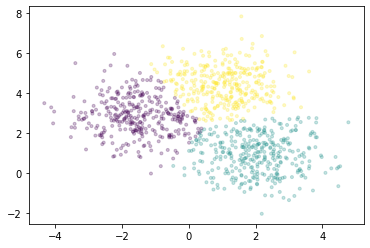

In [7]:
fig, ax = plt.subplots()
ax.scatter(X[::10000, 0], X[::10000, 1], marker='.', c=km.labels_[::10000],
           cmap='viridis', alpha=0.25);

In [8]:
# equivalent task in sklearn without parallelization
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=10000000, centers=3, n_features=2, random_state=0)
print(X.shape)

(10000000, 2)


In [9]:
%%time
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3, max_iter=2)
km.fit(X)

Wall time: 1min


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=2,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

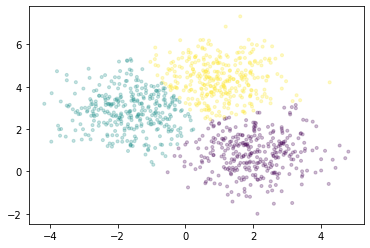

In [10]:
fig, ax = plt.subplots()
ax.scatter(X[::10000, 0], X[::10000, 1], marker='.', c=km.labels_[::10000],
           cmap='viridis', alpha=0.25);

### XGBoost with Dask
Dask-ML can set up distributed XGBoost for you and hand off data from distributed dask.dataframes. This automates much of the hassle of preprocessing and setup while still letting XGBoost do what it does well.

In [11]:
from dask_ml.datasets import make_classification

X, y = make_classification(n_samples=100000, n_features=20,
                           chunks=1000, n_informative=4,
                           random_state=0)
X

dask.array<normal, shape=(100000, 20), dtype=float64, chunksize=(1000, 20), chunktype=numpy.ndarray>

In [12]:
from dask_ml.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [13]:
X_train

dask.array<concatenate, shape=(85000, 20), dtype=float64, chunksize=(850, 20), chunktype=numpy.ndarray>

In [14]:
from dask_ml.xgboost import XGBRegressor # requirements: dask, dask_xgboost, xgboost

In [16]:
est = XGBRegressor()
est.fit(X_train, y_train)

OSError: [WinError 10048] Only one usage of each socket address (protocol/network address/port) is normally permitted

In [17]:
prediction = est.predict(X_test)

AttributeError: 'NoneType' object has no attribute 'attr'

In [8]:
prediction.compute()

array([ 0.5815124 ,  0.22809294,  0.7561211 , ...,  0.5575613 ,
        0.2928226 , -0.06609088], dtype=float32)

In [11]:
from sklearn.metrics import roc_curve
import dask

# Note that the dask.compute() function returns in-memory results. 
# It converts Dask DataFrames to Pandas DataFrames, Dask arrays to NumPy arrays, and Dask bags to lists. 
# You should only call compute on results that will fit comfortably in memory.
y_test, y_hat = dask.compute(y_test, prediction) 
fpr, tpr, _ = roc_curve(y_test, prediction)

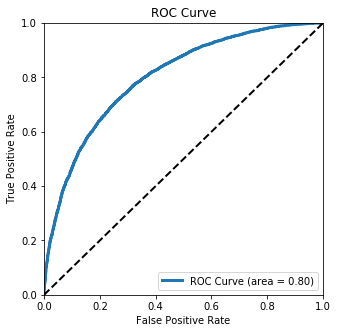

In [13]:
from sklearn.metrics import auc
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, lw=3,
        label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend();
plt.show()

## Work with a cluster using Dask

After we setup a cluster, we initialize a Client by pointing it to the address of a **scheduler**.

The Client is the primary entry point for users of dask.distributed.

A cluster can be one of the followings:
+ Single machine 
+ SSH: Use SSH to set up Dask across an un-managed cluster.
+ High Performance Computers: How to run Dask on traditional HPC environments using tools like MPI, or job schedulers like SLURM, SGE, TORQUE, LSF, and so on.
+ Kubernetes: Deploy Dask with the popular Kubernetes resource manager using either Helm or a native deployment.
+ YARN / Hadoop: Deploy Dask on YARN clusters, such as are found in traditional Hadoop installations.
+ Python API (advanced): Create Scheduler and Worker objects from Python as part of a distributed Tornado TCP application.
+ Cloud for current recommendations on how to deploy Dask and Jupyter on common cloud providers like Amazon, Google, or Microsoft Azure.